<a href="https://colab.research.google.com/github/gitHubAndyLee2020/OpenAI_Gym_RL_Projects/blob/main/lunar_lander_project_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installations

In [2]:
!pip install gymnasium

In [3]:
!pip install swig
!pip install gymnasium[box2d]

In [4]:
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install pyvirtualdisplay
!pip install tf-agents[reverb]
!pip install pyglet

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
freeglut3-dev is already the newest version (2.8.1-6).
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
xvfb is already th

# Set-up

In [5]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
import reverb

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

In [6]:
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

In [7]:
import gym
import tf_agents.environments.suite_gym as suite_gym

# List all available gym environments
available_gym_envs = list(gym.envs.registry.env_specs.keys())
print("Available OpenAI Gym environments:")
for env_name in available_gym_envs:
    print(env_name)

Available OpenAI Gym environments:
CartPole-v0
CartPole-v1
MountainCar-v0
MountainCarContinuous-v0
Pendulum-v1
Acrobot-v1
LunarLander-v2
LunarLanderContinuous-v2
BipedalWalker-v3
BipedalWalkerHardcore-v3
CarRacing-v1
Blackjack-v1
FrozenLake-v1
FrozenLake8x8-v1
CliffWalking-v0
Taxi-v3
Reacher-v2
Pusher-v2
InvertedPendulum-v2
InvertedDoublePendulum-v2
HalfCheetah-v2
HalfCheetah-v3
Hopper-v2
Hopper-v3
Swimmer-v2
Swimmer-v3
Walker2d-v2
Walker2d-v3
Ant-v2
Ant-v3
Humanoid-v2
Humanoid-v3
HumanoidStandup-v2


# Environment Demo

In [8]:
# Load an example environment using suite_gym
env_name = 'LunarLander-v2'
env = suite_gym.load(env_name)

In [9]:
time_step = env.reset()
print('Time step:')
print(time_step)

Time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([-8.0394748e-05,  1.4153266e+00, -8.1626056e-03,  1.9584563e-01,
        1.0000004e-04,  1.8489456e-03,  0.0000000e+00,  0.0000000e+00],
      dtype=float32),
 'reward': array(0., dtype=float32),
 'step_type': array(0, dtype=int32)})


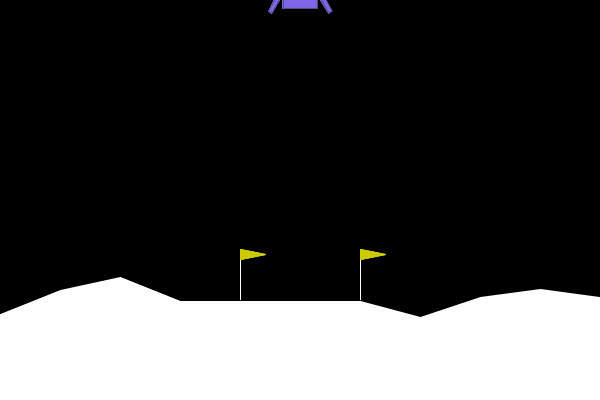

In [10]:
PIL.Image.fromarray(env.render())

### Observation Space
The state is an 8-dimensional vector: the coordinates of the lander in x & y, its linear velocities in x & y, its angle, its angular velocity, and two booleans that represent whether each leg is in contact with the ground or not.

In [11]:
print('Observation Spec:')
print(env.time_step_spec().observation)

Observation Spec:
BoundedArraySpec(shape=(8,), dtype=dtype('float32'), name='observation', minimum=-3.4028234663852886e+38, maximum=3.4028234663852886e+38)


### Rewards
After every step a reward is granted. The total reward of an episode is the sum of the rewards for all the steps within that episode.

For each step, the reward:

is increased/decreased the closer/further the lander is to the landing pad.

is increased/decreased the slower/faster the lander is moving.

is decreased the more the lander is tilted (angle not horizontal).

is increased by 10 points for each leg that is in contact with the ground.

is decreased by 0.03 points each frame a side engine is firing.

is decreased by 0.3 points each frame the main engine is firing.

The episode receive an additional reward of -100 or +100 points for crashing or landing safely respectively.

An episode is considered a solution if it scores at least 200 points.

In [12]:
print('Reward Spec:')
print(env.time_step_spec().reward)

Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


### Action Space
There are four discrete actions available:

0: do nothing

1: fire left orientation engine

2: fire main engine

3: fire right orientation engine

In [13]:
print('Action Spec:')
print(env.action_spec())

Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=3)


In [14]:
# Create a TF-Py environment wrapper
tf_env = tf_py_environment.TFPyEnvironment(env)

# Initialize a random policy
action_spec = tensor_spec.from_spec(tf_env.action_spec())
time_step_spec = tensor_spec.from_spec(tf_env.time_step_spec())
random_policy = random_tf_policy.RandomTFPolicy(time_step_spec, action_spec)

# Initial time_step
time_step = tf_env.current_time_step()
print('Initial Time step:')
print(time_step)

# Take random action and render
for i in range(500):
    action_step = random_policy.action(time_step)
    action = action_step.action
    # print('Random Action:', action.numpy())

    time_step = tf_env.step(action)

    # print('Time step after action:')
    # print(time_step)

Initial Time step:
TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 8), dtype=float32, numpy=
array([[-0.00258732,  1.4189514 , -0.26208207,  0.35693848,  0.00300484,
         0.05936556,  0.        ,  0.        ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})


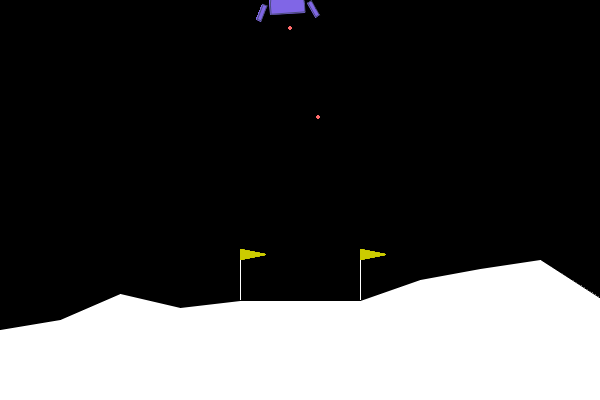

In [15]:
PIL.Image.fromarray(env.render())

# Model

In [48]:
num_iterations = 10000

initial_collect_steps = 1000
collect_steps_per_iteration = 1
replay_buffer_max_length = 200000

batch_size = 64
learning_rate = 1e-4
log_interval = 200

num_eval_episodes = 10
eval_interval = 1000

fc_layer_params = (100, 50)

In [49]:
env_name = 'LunarLander-v2'
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

In [50]:
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [51]:
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

def dense_layer(num_units):
  return tf.keras.layers.Dense(
      num_units,
      activation=tf.keras.activations.relu,
      kernel_initializer=tf.keras.initializers.VarianceScaling(
          scale=2.0, mode='fan_in', distribution='truncated_normal'))

dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))
q_net = sequential.Sequential(dense_layers + [q_values_layer])

In [52]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

In [53]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

### Random Policy Example

In [54]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

In [55]:
example_environment = tf_py_environment.TFPyEnvironment(
    suite_gym.load('LunarLander-v2'))

In [56]:
time_step = example_environment.reset()

In [57]:
random_policy.action(time_step)

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int64, numpy=array([3])>, state=(), info=())

In [58]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

In [59]:
compute_avg_return(eval_env, random_policy, num_eval_episodes)

-179.45102

### Replay Buffer

In [60]:
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(3),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=2,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  replay_buffer.py_client,
  table_name,
  sequence_length=2)

In [61]:
agent.collect_data_spec

Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(3)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': BoundedTensorSpec(shape=(8,), dtype=tf.float32, name='observation', minimum=array(-3.4028235e+38, dtype=float32), maximum=array(3.4028235e+38, dtype=float32)),
 'policy_info': (),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

In [62]:
agent.collect_data_spec._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

### Data Collection

In [63]:
py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      random_policy, use_tf_function=True),
    [rb_observer],
    max_steps=initial_collect_steps).run(train_py_env.reset())

(TimeStep(
 {'discount': array(1., dtype=float32),
  'observation': array([-0.22797866,  0.56960094, -0.17284247, -1.199213  , -0.12494626,
        -0.12402736,  0.        ,  0.        ], dtype=float32),
  'reward': array(-0.8110361, dtype=float32),
  'step_type': array(1, dtype=int32)}),
 ())

In [64]:
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

dataset

<_PrefetchDataset element_spec=(Trajectory(
{'action': TensorSpec(shape=(64, 2), dtype=tf.int64, name=None),
 'discount': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'next_step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'observation': TensorSpec(shape=(64, 2, 8), dtype=tf.float32, name=None),
 'policy_info': (),
 'reward': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None)}), SampleInfo(key=TensorSpec(shape=(64, 2), dtype=tf.uint64, name=None), probability=TensorSpec(shape=(64, 2), dtype=tf.float64, name=None), table_size=TensorSpec(shape=(64, 2), dtype=tf.int64, name=None), priority=TensorSpec(shape=(64, 2), dtype=tf.float64, name=None), times_sampled=TensorSpec(shape=(64, 2), dtype=tf.int32, name=None)))>

In [65]:
iterator = iter(dataset)
print(iterator)

### Agent Training

In [66]:
try:
  %%time
except:
  pass

agent.train = common.function(agent.train)

agent.train_step_counter.assign(0)

avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

time_step = train_py_env.reset()

collect_driver = py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      agent.collect_policy, use_tf_function=True),
    [rb_observer],
    max_steps=collect_steps_per_iteration)

for _ in range(num_iterations):

  time_step, _ = collect_driver.run(time_step)

  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)
    create_policy_eval_video(agent.policy, f"trained-agent-{version}-e{step}")

step = 200: loss = 15.606161117553711
step = 400: loss = 16.50469970703125
step = 600: loss = 14.780160903930664
step = 800: loss = 254.55093383789062
step = 1000: loss = 241.3979034423828


step = 1000: Average Return = -119.70829010009766
step = 1200: loss = 126.70697784423828
step = 1400: loss = 117.23365783691406
step = 1600: loss = 42.2257080078125
step = 1800: loss = 24.962026596069336
step = 2000: loss = 16.56503677368164


step = 2000: Average Return = -139.2804412841797
step = 2200: loss = 42.36909866333008
step = 2400: loss = 9.641694068908691
step = 2600: loss = 303.8104248046875
step = 2800: loss = 117.39070129394531
step = 3000: loss = 45.745113372802734


step = 3000: Average Return = -73.18756103515625
step = 3200: loss = 136.7333984375
step = 3400: loss = 7.894498348236084
step = 3600: loss = 81.40168762207031
step = 3800: loss = 58.194942474365234
step = 4000: loss = 121.26282501220703


step = 4000: Average Return = 217.707763671875
step = 4200: loss = 96.38289642333984
step = 4400: loss = 55.8167610168457
step = 4600: loss = 274.4626770019531
step = 4800: loss = 5.902492523193359
step = 5000: loss = 10.097698211669922


step = 5000: Average Return = 61.255218505859375
step = 5200: loss = 2.6069209575653076
step = 5400: loss = 154.16448974609375
step = 5600: loss = 6.507708549499512
step = 5800: loss = 65.38648986816406
step = 6000: loss = 18.183629989624023


step = 6000: Average Return = -78.98057556152344
step = 6200: loss = 6.7232346534729
step = 6400: loss = 81.38539123535156
step = 6600: loss = 30.698083877563477
step = 6800: loss = 38.363033294677734
step = 7000: loss = 5.468827247619629


step = 7000: Average Return = 57.7569580078125
step = 7200: loss = 4.134213447570801
step = 7400: loss = 155.2643585205078
step = 7600: loss = 4.8947553634643555
step = 7800: loss = 7.348330497741699
step = 8000: loss = 6.784642219543457


step = 8000: Average Return = -224.0669708251953
step = 8200: loss = 201.09751892089844
step = 8400: loss = 92.56938171386719
step = 8600: loss = 98.31472778320312
step = 8800: loss = 7.8268656730651855
step = 9000: loss = 140.69189453125


step = 9000: Average Return = -224.3450927734375
step = 9200: loss = 14.909100532531738
step = 9400: loss = 82.23263549804688
step = 9600: loss = 2.6864681243896484
step = 9800: loss = 10.233474731445312
step = 10000: loss = 92.27433013916016


step = 10000: Average Return = -217.4869842529297


(-703.0771881103516, 250.0)

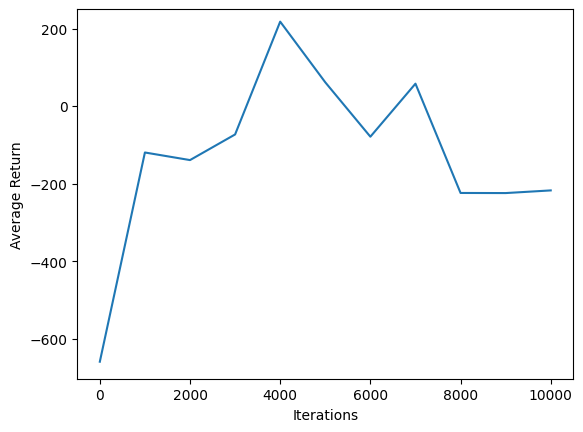

In [67]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=250)

In [43]:
version = "v9"

In [68]:
import json

description = """
- Same as base model v1, but with optimal amount of training epochs
"""
history = {
    "num_iterations": num_iterations,
    "initial_collect_steps": initial_collect_steps,
    "collect_steps_per_iteration": collect_steps_per_iteration,
    "replay_buffer_max_length": replay_buffer_max_length,
    "batch_size": batch_size,
    "learning_rate": learning_rate,
    "log_interval": log_interval,
    "num_eval_episodes": num_eval_episodes,
    "eval_interval": eval_interval,
    "fc_layer_params": fc_layer_params,
    "returns": [float(x) for x in returns],
    "description": description,
}

# Save the dictionary as a JSON file
filename = f"history-{version}.json"
with open(filename, 'w') as f:
    json.dump(history, f, indent=4)

print(f"Saved history to {filename}")

Saved history to history-v9.json


In [46]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  '''.format(b64.decode())

  return IPython.display.HTML(tag)

In [47]:
def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return embed_mp4(filename)

In [ ]:
create_policy_eval_video(agent.policy, f"trained-agent-{version}")

In [38]:
create_policy_eval_video(random_policy, "random-agent")